### 분류문제
집값 예측의 경우 정확한 수치를 예측하는 회귀 문제였다. 이번에는 분류 문제를 살펴본다.

### MNIST


In [1]:
from sklearn.datasets import fetch_openml
import warnings

warnings.filterwarnings("ignore")

mnist = fetch_openml("mnist_784", version = 1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np

X, y = mnist["data"], mnist["target"] # define input, label data
print(X.shape, y.shape) # 이미지 데이터를 2차원으로 변경한 (70000, 784(28x28x1)) 크기의 x 데이터와 그의 라벨값인 y(70000, )을 확인할 수 있다.
y = y.astype(np.uint8) # y의 전체 타입을 정수로 변환

(70000, 784) (70000,)


### 데이터셋 살펴보기
현재 가로, 세로 28픽셀과 1개의 채널(흑백)을 가진 데이터이기에, 샘플의 특성 벡터를 추출해서 28x28 크기의 배열로 바꾸고 시각화합니다.

(784,)


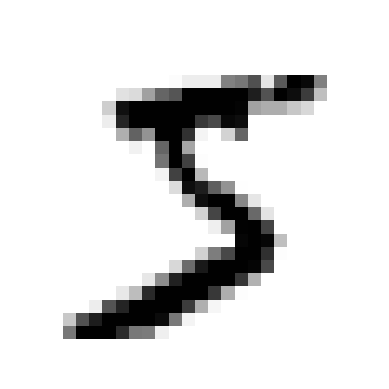

In [3]:
import matplotlib.pyplot as plt, matplotlib as mlp

some_digit = X[0]
print(some_digit.shape)
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary") # cmap = color map, binary : 흑색 이미지를 시각화하기 위한 색상맵.
plt.axis("off")
plt.show()

### 데이터셋 분할하기
MNIST 데이터셋의 경우 앞쪽 60000개, 뒤쪽 10000개로 train, test셋을 분할해놓은 데이터셋입니다. 그에 맞게 데이터를 분할합니다.

In [4]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

### 이진 분류기 훈련하기
이진 분류란, 두 개의 클래스로 분류하는 행위를 일컫습니다. 이를테면 해당 이미지가 개인지 아닌지를 구별하는 문제가 되겠죠. 임시 타겟 벡터를 생성하여 모델을 훈련해보겠습니다.

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**확률적 경사 하강법 분류기**를 이용해서 분류를 시작합니다. 해당 모델의 경우 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가지고 있습니다. 한 번에 하나씩 독립적으로 샘플들을 처리합니다.

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
y_pred = sgd_clf.predict([some_digit])
y_pred, type(y_pred)

(array([ True]), numpy.ndarray)

### 성능 측정하기
교차검증을 이용한 정확도 측정을 진행합니다.

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_cf = clone(sgd_clf)               # 모델 복사
    X_train_folds = X_train[train_index]    # n폴드에 해당하는 훈련셋과
    X_test_folds = X_train[test_index]      # 테스트셋 생성
    y_train5_folds = y_train_5[train_index] # n폴드에 해당하는 라벨 훈련셋과
    y_test5_folds = y_train_5[test_index]   # 테스트셋 생성
    
    clone_cf.fit(X_train_folds, y_train5_folds) # 나눈 폴드를 기준으로 학습하고
    y_pred = clone_cf.predict(X_test_folds)     # 예측을 진행한다.
    n_correct = sum(y_pred == y_test5_folds)    # 예측을 올바르게 진행한 것들만 남겨서
    print(n_correct / len(y_pred))              # 정확도를 출력한다.

0.9669
0.91625
0.96785


In [9]:
from sklearn.model_selection import cross_val_score

# cross_val_score로 3겹 교차검증을 사용해 확률적 경사하강법 분류기를 평가한다.
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

모든 검증 폴드들에 대해서 95% 이상의 정확도를 기록했다. 모든 이미지를 `5가 아님` 클래스로 분류하는 더미 분류기를 만들어 비교해본다.

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [12]:
# 모델의 정확도 추론
never_5_classifier = Never5Classifier()
cross_val_score(never_5_classifier, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

이미지의 10% 정도만 `5` 이기에 무조건 5 아님 으로 예측하면 정확히 맞출 확률이 90퍼센트입니다.

### 오차(혼동) 행렬
분류기의 성능을 평가하는 방법 중 하나는 오차 행렬을 구해 보는 것이다. 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다. 예를 들어 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.

오차 행렬을 만들려면 실제 타겟과 비교할 수 있도록 먼저 예측값을 만들어야 한다. 일반적으로 테스트 세트를 이용해서 만들 수 있지만, 실제 서비스 단계에서 테스트 세트를 사용하는 시기는 프로젝트의 맨 마지막 단에서 사용하기에, `cross_val_predict`를 이용한다. 

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

cross_val_score 함수처럼 cross_val_predict함수는 k-겹 교차검증을 수행하지만, 평가 점수를 반환하는 것이 아니라 각 테스트 폴드에서 얻은 예측값을 반환합니다. 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다(여기서 깨끗한 예측이란, 한 번도 학습에 사용되지 않은 데이터를 기반으로 예측값을 얻는 것을 의미한다.).

이제 `confusion_matrix()` 함수를 사용해서 오차 행렬을 만들어 본다. 

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### 오차행렬 해석법
우선 오차행렬을 살펴보면 아래와 같다.

![screensh](../images/confusion%20matrix.png)

모델을 평가하기 위해서 사용하는 이 오차 행렬은 각 셀을 아래와 같이 해석할 수 있다.

`[prediction of rainning day]`
- 진실 양성 : 현실에서도 비가 왔고 / 모델도 비가 온다고 예측을 했다.
- 거짓 양성 : 현실에서 비가 오지 않았다 / 모델은 비가 온다고 예측을 했다.
- 거짓 음성 : 현실에서 비가 왔다 / 모델은 비가 오지 않는다고 예측을 했다.
- 진실 음성 : 현실에서 비가 오지 않았다 / 모델도 비가 오지 않는다고 예측을 했다.

### 위 분류기에서의 오차행렬
오차행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다. 1번째 행의 경우 negative class인 "5가 아닌 이미지" 에 대한 예측이고, 2번째 행의 경우 positive class인 "5인 이미지"에 대한 예측이다. 아래와 같이 해석할 수 있다.

`[prediction of label 5]`
- 진실 양성 : 5라는 이미지가 아님 / 모델도 5가 아니라고 예측
- 거짓 양성 : 5라는 이미지가 아님 / 모델은 5라고 예측
- 거짓 음성 : 5라는 이미지 / 모델은 5가 아니라고 예측
- 진실 음성 : 5라는 이미지 / 모델은 5라고 예측함

만약 분류기가 완벽한 분류기라고 하면, 오차 행렬의 주대각성분을 제외한 나머지 성분들은 0일 것이다. 진실 양성과 진실 음성만 가지고 있을 것이기 때문이다.

In [16]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

오차 행렬이 많은 정보를 제공하는 것은 맞으나, 가끔은 더 간소화된 정보를 필요로 하는 때가 있다. 이럴 때 참고할 수 있는것이 양성 예측의 정확도이다. 이를 분류기의 `정밀도`라고 한다.

> 정밀도 = TP / (TP + FP)

TP는 진실 양성의 수이고, FP는 거짓 양성의 수이다.

이러한 정밀도는 재현율이라는 또 다른 지표와 같이 사용하는 것이 일반적이다. 재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 `민감도`, 또는 `진짜 양성 비율`이라고 한다. 재현율의 식은 아래와 같다.

> 재현율 = TP / (TP + FN)

### 정밀도와 재현율

In [19]:
from sklearn.metrics import precision_score, recall_score

print(f"분류기의 정밀도 : {precision_score(y_train_5, y_train_pred)}")
print(f"분류기의 재현율 : {recall_score(y_train_5, y_train_pred)}")

분류기의 정밀도 : 0.8370879772350012
분류기의 재현율 : 0.6511713705958311


### F1-Score 
정밀도와 재현율을 F1-Score라는 하나의 숫자로 만들면 편할때가 있다. 두 분류기를 비교할 때 자주 사용하는데, `F1-Score`의 경우 `정밀도와 재현율의 조화평균`을 구한 것이다. 식은 아래와 같다.

> F<sub>1</sub> = TP / (TP + (FN + FP) / 2)

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 모델에서는 F1-Score가 높게 책정되는 편이다. 하지만 이 지표가 무조건적인 지표는 아니며, 상황에 따라 정밀도가 높아야 하는 경우, 재현율이 높아야 하는 경우가 따로 존재한다. 예시를 들어본다면 아래와 같다.

`[video classification for child]`
- 재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것 보다 좋은 동영상이 많이 제외 되더라도(낮은 재현율) 안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호할 것이다.

`[detection of petty theft]`
- 분류기의 재현율이 99%라면 정밀도가 30%만 되더라도 괜찮을지 모른다. 아마 경비원이 잘못된 호출을 종종 받겠지만 거의 모든 좀도둑을 잡을 수 있게 될 것이다.

이렇듯, 실제 사례들에서 이 두 마리의 토끼를 모두 잡기란, 어려운 일이다. 정밀도를 올리면 재현율이 떨어지고, 재현율을 올리고자 하면 정밀도가 떨어지게 될 것이다. 이를 `정밀도/재현율 트레이드 오프`라고 한다.

### 정밀도/재현율 트레이드 오프
위에서 훈련시킨 확률적 경사 하강법 분류기를 이용해 정밀도/재현율 트레이드 오프를 이해한다.

우선, 해당 분류기는 결정 함수를 사용하여 각 샘플의 점수를 계산한다. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다. 아래 그림은 가장 낮은 점수부터 가장 높은 점수까지 몇 개의 숫자를 나열한 그림이다. 결정 임곗값이 가운데(두 개의 숫자 5 사이)라고 가정하면, 임곗값 오른쪽에 4개의 진실 양성(실제 숫자 5)과 1개의 거짓 양성(실제 숫자 6)이 있다. 그렇기 때문에 가운데 임곗값에서 정밀도는 80%(5개중 4개)이다. 하지만 실제 숫자 5는 6개이고, 분류기는 4개만 감지했으므로 재현율은 67%(6개 중 4개)이다. 이번엔 임곗값을 높이면 거짓 양성(숫자 6)이 진짜 음성이 되어 정밀도는 100%(3개 중 3개)가 된다. 하지만 진짜 양성 하나가 거짓 음성이 되었으므로 재현율이 50%(6개 중 3개)로 줄어든다. 반대로 임곗값을 내리면 재현율이 높아지고 정밀도가 줄어든다.

<div align=center><img src = "../images/tradeoff.png"></div>

이 임곗값을 scikit-learn에서 직접 지정할 수는 없지만, 예측에 사용한 점수는 확인할 수 있다. 분류기의 predict() 메소드 대신에 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다. 이러한 점수들을 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


SGDClassifier의 임곗값이 0이므로 위 코드는 predict() 메소드와 같은 결과(즉, True)를 반환한다. 임곗값을 높이면?

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


임곗값이 높아짐에 따라 재현율이 낮아지는 현상을 확인할 수 있다.